<img src="https://docs.luxonis.com/images/depthai_logo.png" width="500">

# DataDreamer Tutorial: Generating a dataset for object detection, training a model, and deploying it to the OAK (optional)

In [ ]:
!pip install datadreamer

## Generate a dataset with your own classes (might take some time to download all models)

Make sure you are using the GPU runtime type (in Google Colab).

~8 min to generate 100 images

~2 min to annotate them

In [ ]:
!datadreamer --save_dir generated_dataset \
             --class_names robot tractor horse car person bear \
             --prompts_number 100 \
             --disable_lm_filter \
             --prompt_generator simple \
             --num_objects_range 2 3 \
             --image_generator sdxl-turbo \
             --use_tta \
             --image_annotator owlv2 \
             --conf_threshold 0.15 \
             --seed 42

### Parameters
- `--save_dir` (required): Path to the directory for saving generated images and annotations.
- `--class_names` (required): Space-separated list of object names for image generation and annotation. Example: `person moon robot`.
- `--prompts_number` (optional): Number of prompts to generate for each object. Defaults to `10`.
- `--annotate_only` (optional): Only annotate the images without generating new ones, prompt and image generator will be skipped. Defaults to `False`.
- `--task`: Choose between detection, classification and instance segmentation. Default is `detection`.
- `--dataset_format`: Format of the dataset. Defaults to `raw`. Supported values: `raw`, `yolo`, `coco`, `luxonis-dataset`, `cls-single`.
- `--split_ratios`: Split ratios for train, validation, and test sets. Defaults to `[0.8, 0.1, 0.1]`.
- `--num_objects_range`: Range of objects in a prompt. Default is 1 to 3.
- `--prompt_generator`: Choose between `simple`, `lm` (Mistral-7B), `tiny` (tiny LM), and `qwen2` (Qwen2.5 LM). Default is `qwen2`.
- `--image_generator`: Choose image generator, e.g., `sdxl`, `sdxl-turbo` or `sdxl-lightning`. Default is `sdxl-turbo`.
- `--image_annotator`: Specify the image annotator, like `owlv2` for object detection or `clip` for image classification or `owlv2-slimsam` for instance segmentation. Default is `owlv2`.
- `--conf_threshold`: Confidence threshold for annotation. Default is `0.15`.
- `--annotation_iou_threshold`: Intersection over Union (IoU) threshold for annotation. Default is `0.2`.
- `--prompt_prefix`: Prefix to add to every image generation prompt. Default is `""`.
- `--prompt_suffix`: Suffix to add to every image generation prompt, e.g., for adding details like resolution. Default is `", hd, 8k, highly detailed"`.
- `--negative_prompt`: Negative prompts to guide the generation away from certain features. Default is `"cartoon, blue skin, painting, scrispture, golden, illustration, worst quality, low quality, normal quality:2, unrealistic dream, low resolution,  static, sd character, low quality, low resolution, greyscale, monochrome, nose, cropped, lowres, jpeg artifacts, deformed iris, deformed pupils, bad eyes, semi-realistic worst quality, bad lips, deformed mouth, deformed face, deformed fingers, bad anatomy"`.
- `--use_tta`: Toggle test time augmentation for object detection. Default is `False`.
- `--synonym_generator`: Enhance class names with synonyms. Default is `none`. Other options are `llm`, `wordnet`.
- `--use_image_tester`: Use image tester for image generation. Default is `False`.
- `--image_tester_patience`: Patience level for image tester. Default is `1`.
- `--lm_quantization`: Quantization to use for Mistral language model. Choose between `none` and `4bit`. Default is `none`.
- `--annotator_size`: Size of the annotator model to use. Choose between `base` and `large`. Default is `base`.
- `--disable_lm_filter`: Use only a bad word list for profanity filtering. Default is `False`.
- `--keep_unlabeled_images`: Whether to keep images without any annotations. Default if `False`.
- `--batch_size_prompt`: Batch size for prompt generation. Default is 64.
- `--batch_size_annotation`: Batch size for annotation. Default is `1`.
- `--batch_size_image`: Batch size for image generation. Default is `1`.
- `--device`: Choose between `cuda` and `cpu`. Default is `cuda`.
- `--seed`: Set a random seed for image and prompt generation. Default is `42`.
- `--config`: A path to an optional `.yaml` config file specifying the pipeline's arguments.


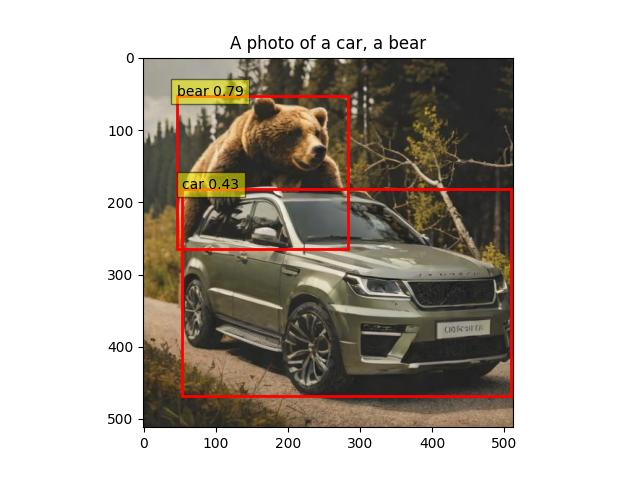

In [ ]:
import os

from IPython.display import Image

Image(filename=os.path.join("generated_dataset/bboxes_visualization", "bbox_70.jpg"))

## Convert the dataset to YOLO format

In [1]:
from datadreamer.utils.convert_dataset import convert_dataset

In [5]:
convert_dataset(
    input_dir="generated_dataset",
    output_dir="generated_dataset_yolo",
    dataset_format="yolo",
    split_ratios=[0.8, 0.1, 0.1],
    copy_files=True,
)

In [ ]:
!ls generated_dataset_yolo

data.yaml  train  val


# Train your model (YOLOv8 as an example)

In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # load a pretrained model

100%|██████████| 6.23M/6.23M [00:00<00:00, 327MB/s]


In [ ]:
results = model.train(data="generated_dataset_yolo/data.yaml", epochs=50)

## Show the predictions

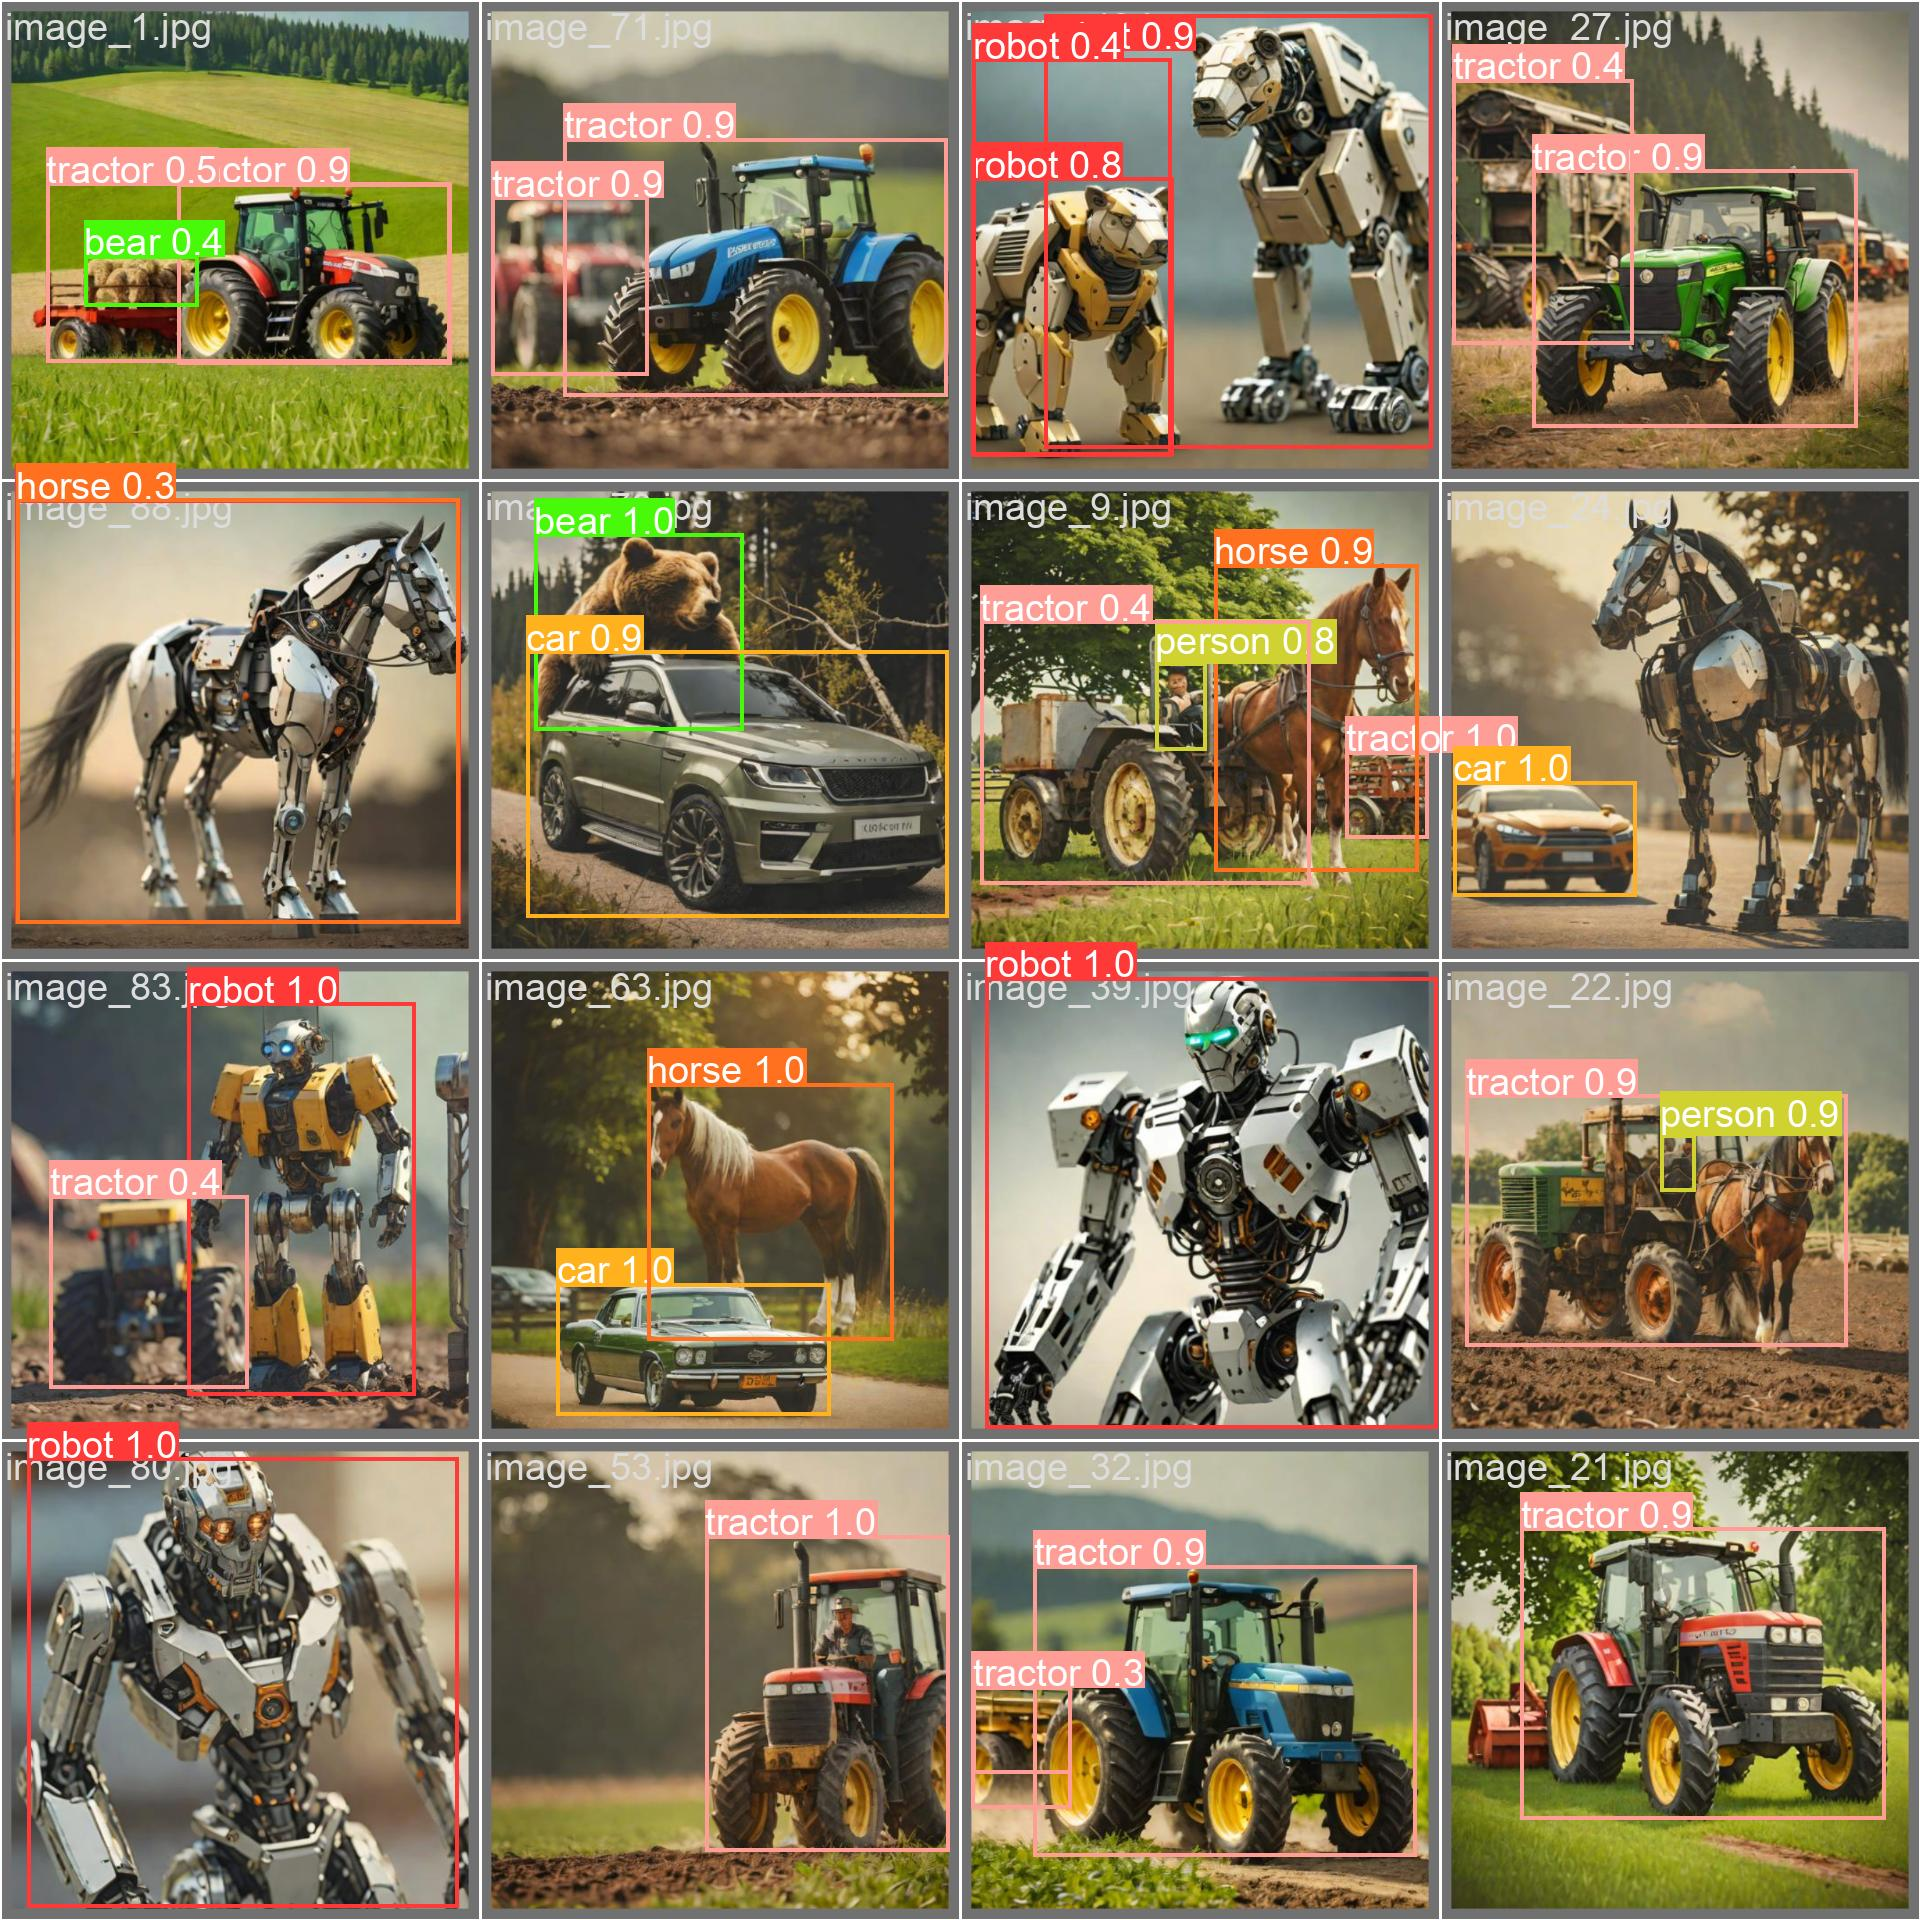

In [ ]:
Image(filename=os.path.join(results.save_dir, "val_batch0_pred.jpg"))

In [ ]:
metrics = model.val()

Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/generated_dataset_yolo/val/labels.cache... 21 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


                   all         21         51      0.684      0.667      0.715      0.553
                 robot         21         17      0.863      0.471       0.58      0.445
               tractor         21         13      0.852      0.884      0.948      0.799
                 horse         21          4       0.65       0.75      0.912      0.841
                   car         21         10      0.393        0.3      0.257       0.18
                person         21          5      0.966        0.6      0.596       0.26
                  bear         21          2      0.382          1      0.995      0.796
Speed: 0.3ms preprocess, 20.6ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/train2


## [Optional] Deploying to OAK

### Generating the .blob file using [tools.luxonis.com](http://tools.luxonis.com)
After the training and validation, you can convert the fine-tuned PyTorch model to a `.blob` format.

Please follow these steps to do so:
1.   Download the fine-tuned weights from `runs/detect/train/weights/best.pt` to your device (as shown in screenshot below)
2.   Go to the page [tools.luxonis.com](http://tools.luxonis.com)
3.   On the page set Yolo Version to `YoloV8 (detection only)` ( (as shown in the screeenshot below)
4.   On the page set File to the downloaded `best` weights (as shown in the screeenshot below)
5.   On the page set Input shape to `640` (as shown in the screeenshot below)


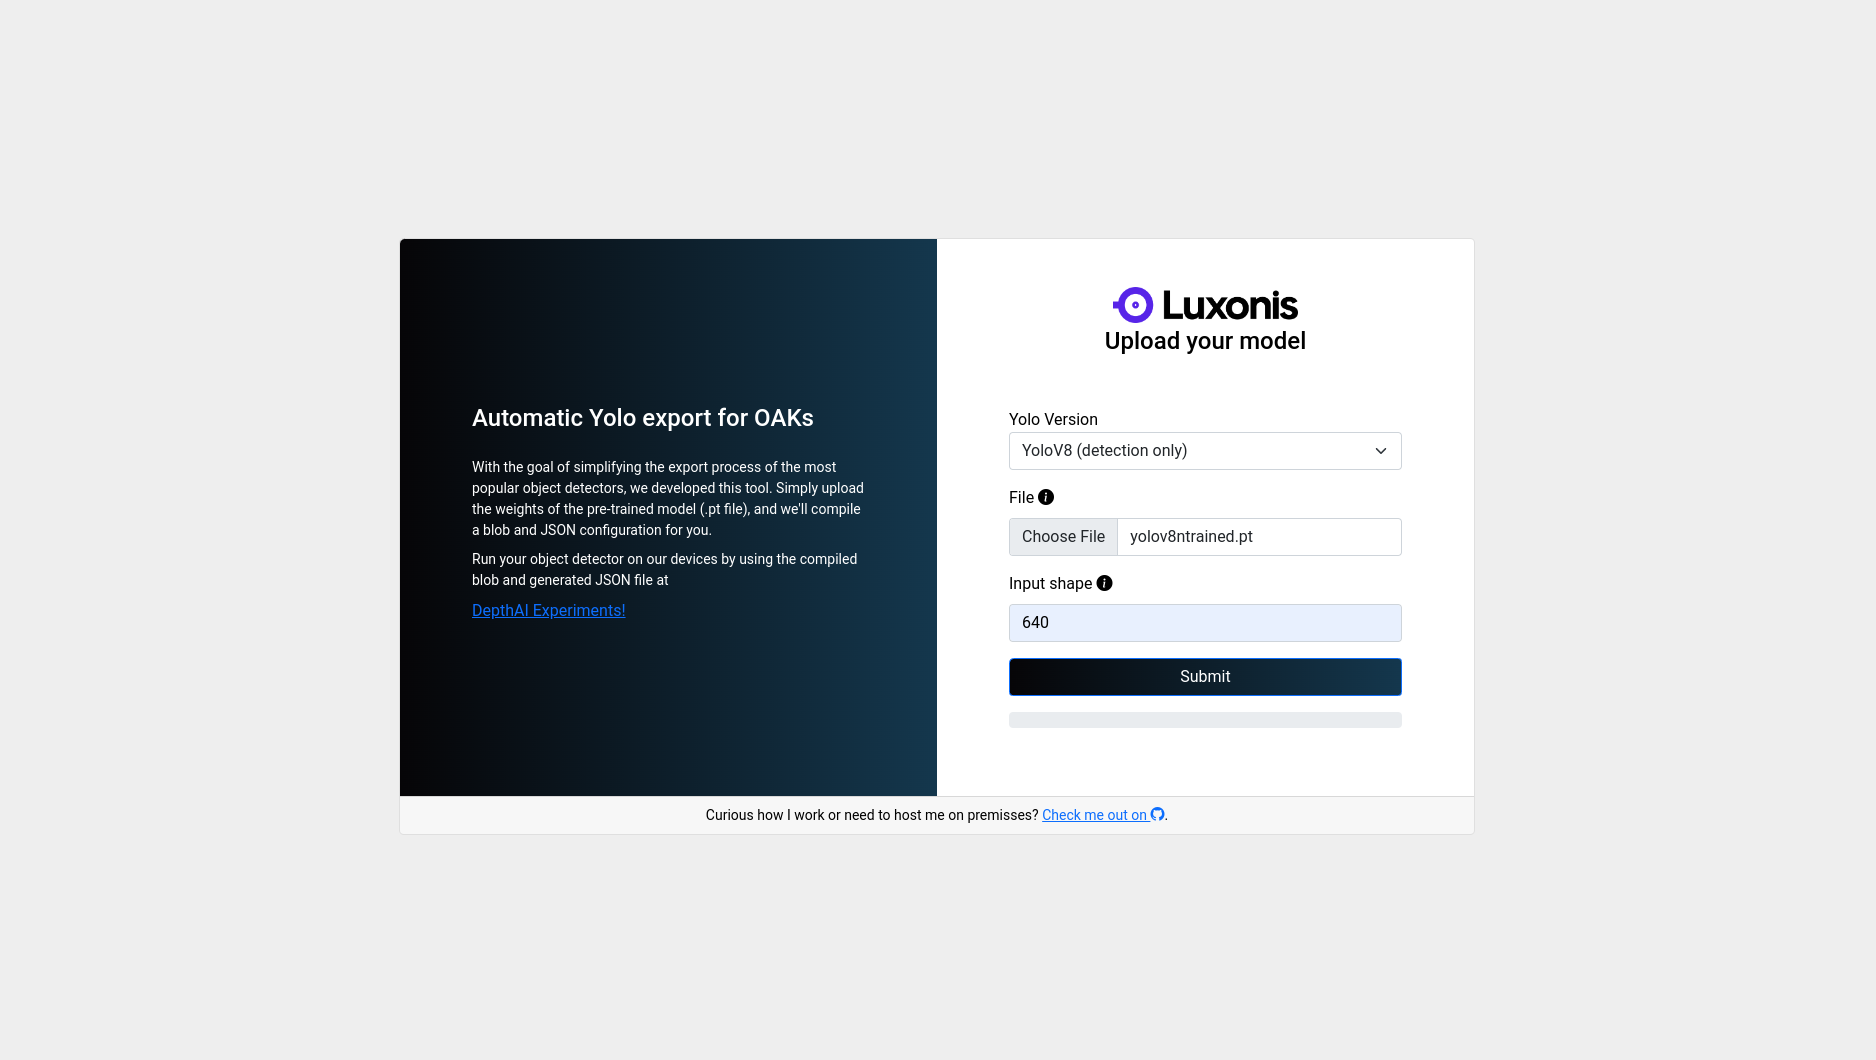

### Next steps

After the tool converts the model to the `blob`, it will compress the converted `blob` file alongside a corresponding `JSON` config file and intermediate `ONNX` and `OpenVINO` representations and automatically download the compressed folder.

The `JSON` config file contains the following parameters: 
* *input_size* - input shape of the model,
* *num_classes* - number of classes that Yolo can detect, 
* *coordinates* - the size of coordinates *(4 by default)*,
* *anchors* - Yolo anchors,
* *iou_threshold* - intersection over union threshold,
* *confidence_threshold* - confidence threshold above which objects are detected,
* *anchor_masks* - set the anchor masks as described in the next section,
* *labels* - labels of the objects that Yolo can detect.

To run the converted blob on an OAK device with on-device encoding, please visit the [depthai-experiments/gen2-yolo/device-decoding](https://github.com/luxonis/depthai-experiments/tree/master/gen2-yolo/device-decoding) repository. We provide the instructions in the README folder.


1.   Clone the repository using `git clone git@github.com:luxonis/depthai-experiments.git`
2.   Go to the `depthai-experiments/gen2-yolo/device-decoding/` folder
3.   Install the required dependencies using `python3 -m pip install -r requirements.txt`
     
     **Note: For the YoloV8 models to work properly, you have to use the DepthAI library in version `2.18.0.0` or newer! To update the DepthAI library use this command: `pip install depthai --upgrade`.**
4.   Extract the downloaded folder and move the files to the `depthai-experiments/gen2-yolo/device-decoding/` folder
5.   Run the app using `python3 main.py --config best.json`